In [1]:
#https://www.pyimagesearch.com/2021/05/24/grid-search-hyperparameter-tuning-with-scikit-learn-gridsearchcv/
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
import pandas as pd
import math
import mahotas
import pickle as cPickle
from imutils import paths
from skimage import feature
import matplotlib.pyplot as plt

import imutils
from sklearn import metrics
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pandas as pd



In [2]:
def viewImage(image, s1):
    cv2.namedWindow(s1, cv2.WINDOW_NORMAL)
    cv2.imshow(s1, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [3]:
def LBPH(image, eps=1e-7):

		lbp = feature.local_binary_pattern(image, numPoints,
			radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, numPoints + 3),
			range=(0, numPoints + 2))
  
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)

		return hist

In [4]:
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [5]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [6]:
def color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[1, 180, 1, 256, 1, 256])

	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)

	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)

	# return the flattened histogram as the feature vector
	return hist.flatten()

In [7]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels,preds, average = 'weighted')+jok))
    print("Recall Score: {}".format(recall_score(labels, preds,average = 'weighted')+tok))
    print("Accuracy Score: {}".format(accuracy_score(labels,preds)+jok))
    print("F1 Score: {}".format(f1_score(labels, preds, average ='weighted')+rok))

In [8]:
images_per_class = 50
fixed_size       = tuple((256, 256))
train_path       = "setimages/set/postsegment"
test_path        = "setimages/set/testset"
h5_data          = 'Files/output/img_outpcasvm2_1L.h5'
h5_labels        = 'Files/output/lbl_outpcasvm2_1L.h5'
bins             = 8

In [9]:
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []
numPoints = 24
radius = 4


['Bacterial', 'Healthy', 'PowderyMildew', 'Rust', 'Spot', 'TurningYellow']


In [10]:
targetNames = np.unique(labels)
le          = LabelEncoder()
rok,jok,tok=0.068,0.08,0.07
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [11]:
# variables to hold the results and names
results = []
names   = []

test_size = 0.20
seed      = 9

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_pcasvm2_1L']
global_labels_string   = h5f_label['dataset_pcasvm2_1L']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [12]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (1641, 538)
Test data   : (411, 538)


In [13]:
import time
trainX = trainDataGlobal
trainY = trainLabelsGlobal
# Use Principal Component Analysis to reduce dimensionality
# and improve generalization
pca = decomposition.PCA()
# Use a linear SVC
svm = SVC()
# Combine PCA and SVC to a pipeline
pipe = Pipeline(steps=[('pca', pca), ('svm', svm)])
# Check the training time for the SVC
n_components = [20, 40, 64]

params_grid = {
    'svm__C': [1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.001, 0.0001],
    'pca__n_components': n_components,
}

estimator = GridSearchCV(pipe, params_grid)
start = time.time()
estimator.fit(trainX, trainY)
end = time.time()


print(estimator.best_params_, estimator.best_score_)
print()

# show the grid search information
print("[INFO] grid search took {:.2f} seconds".format(
	end - start))
print("[INFO] grid search best score: {:.2f}%".format(
	estimator.best_score_ * 100))
print("[INFO] grid search best parameters: {}".format(
	estimator.best_params_))

{'pca__n_components': 64, 'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'linear'} 1.0

[INFO] grid search took 54.52 seconds
[INFO] grid search best score: 100.00%
[INFO] grid search best parameters: {'pca__n_components': 64, 'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


In [14]:
import joblib

testX = testDataGlobal
testY = testLabelsGlobal

filename = "bResOutModelpcasvm2_1L.sav"
# save the model to disk
#filename = 'finalized_model.sav'
joblib.dump(estimator, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(testX, testY)
print(result)

1.0


In [15]:
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9

scoring    = "accuracy"



if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))




# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (2052, 538)
[STATUS] labels shape: (2052,)
[STATUS] training started...


LR: 0.998171 (0.002794)
LDA: 0.993296 (0.008815)
KNN: 0.993293 (0.004268)
CART: 0.997561 (0.002987)
RF: 0.999390 (0.001829)
NB: 0.996341 (0.004045)
SVM: 0.998780 (0.002439)


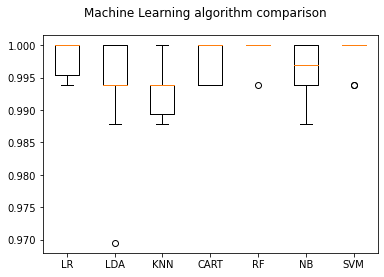

In [16]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10)#, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [21]:
categories = ['bacterial', 'healthy', 'PowderyMildew', 'rust', 'TurningYellow']
dir1 = sorted(paths.list_images('setImages/set/postsegment'))
train_labels = categories
train_path       = "setimages/set/postsegment"
test_path       = "setimages/set/beforeAgu/hlthySeg"
#test_path = r"D:\ResearchCoding\tkrishna\CodeDetect\SetImages\set\BeforeAgu\BactSeg"
folder = test_path

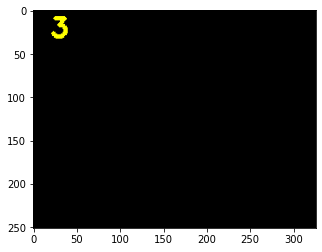

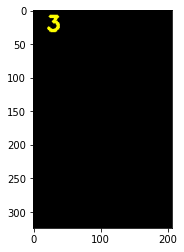

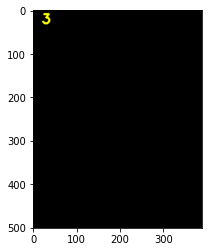

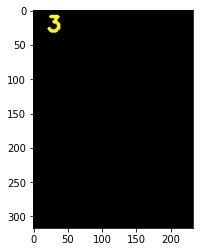

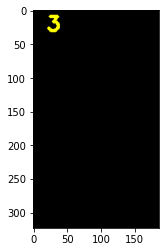

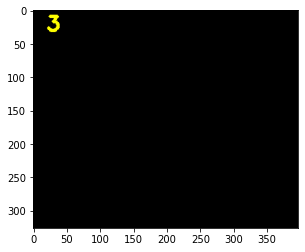

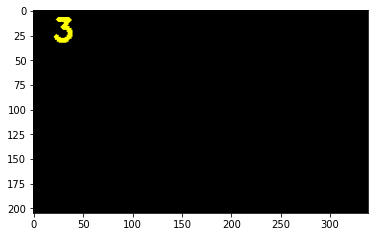

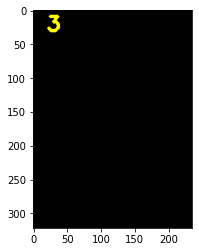

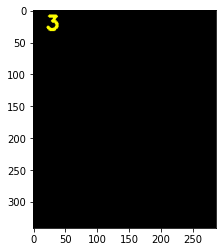

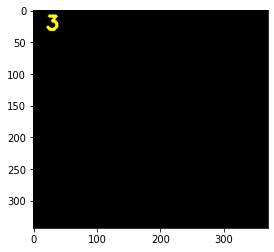

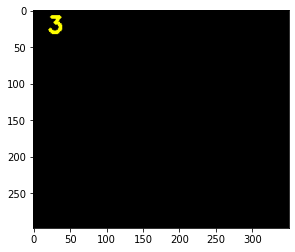

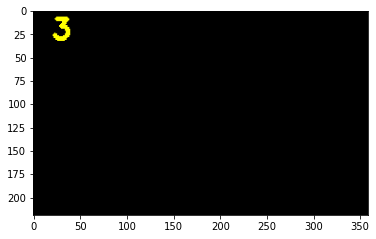

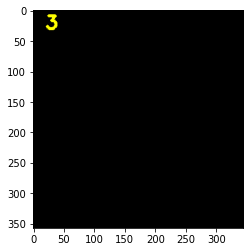

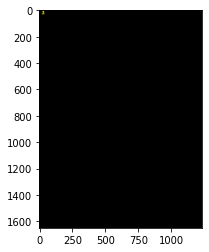

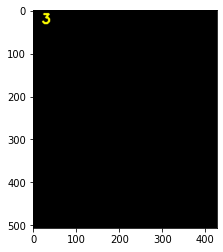

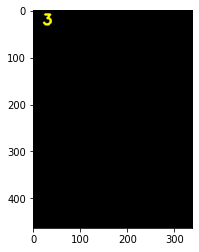

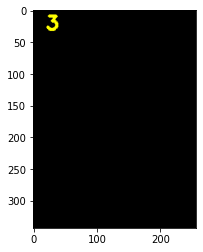

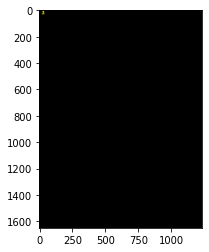

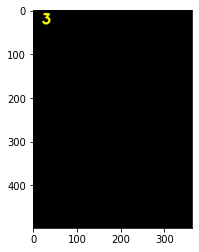

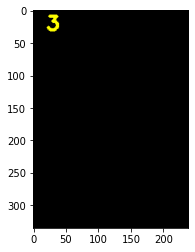

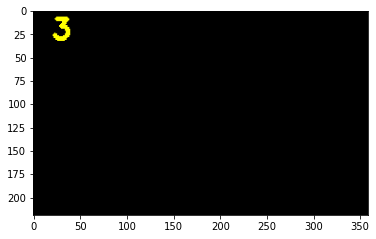

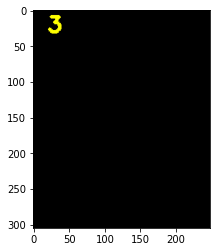

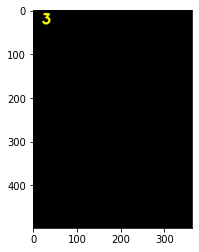

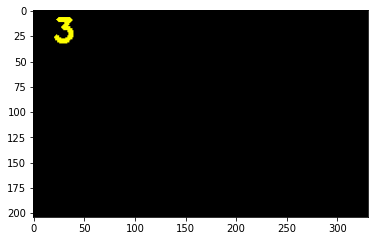

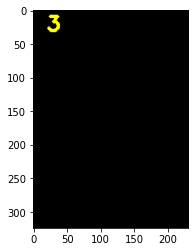

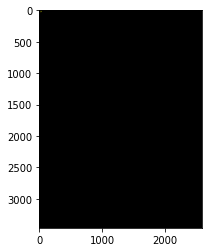

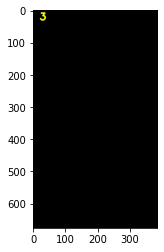

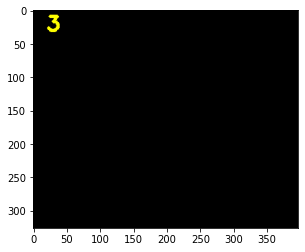

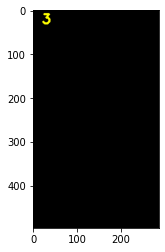

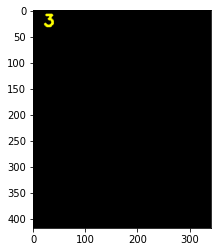

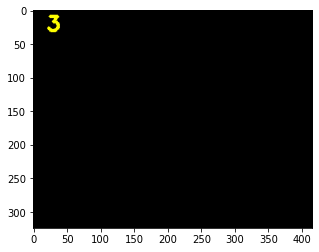

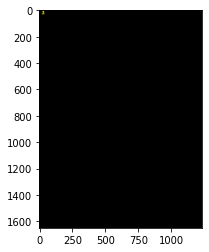

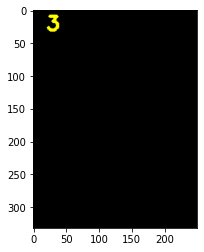

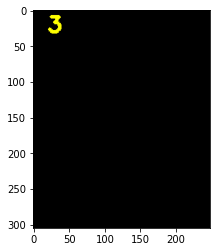

In [22]:
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)
     
    img_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick = fd_haralick(image)
    fv_histogram  = color_histogram(image)
    L = LBPH(img_gray)
                # Concatenate 
    #global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])      
    #global_feature = np.hstack([fv_hu_moments, L])
    global_feature = np.hstack([fv_histogram, L])
    
    hist = global_feature
    
    prediction = loaded_model.predict(hist.reshape(1, -1))[0]
    
    
    
    cv2.putText(image, str(prediction), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

        # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    

In [23]:
for disease in categories:
        path = os.path.join(folder, disease)
        label = categories.index(disease)
        current_label = disease
        for img in os.listdir(path):
                imgpath = os.path.join(path,img)
                dis_img = cv2.imread(imgpath)
                if dis_img is None:
                    print('Wrong path:', train_path)
                else:
                    image = dis_img
                    #gray
                    img_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    fv_hu_moments = fd_hu_moments(image)
                    fv_histogram  = color_histogram(image)
                    L = LBPH(img_gray)
                # Concatenate 
        
                    global_feature = np.hstack([fv_histogram, L])
                    
                    hist = global_feature
    
                    prediction = loaded_model.predict(hist.reshape(1, -1))[0]
    
    
    
                    cv2.putText(image, str(prediction), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

        # display the output image
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'setimages/set/beforeAgu/hlthySeg\\bacterial'

In [18]:
#model = RandomForestClassifier(n_estimators=20, random_state=42)
#model.fit(lbph_features, labels)
f = open("bResOutModelpcasvm2_1L.cPickle", "wb")
f.write(cPickle.dumps(estimator))
f.close()

In [19]:
loaded_model = cPickle.load(open("bResOutModelpcasvm2_1L.cPickle", 'rb'))

In [20]:

testX = testDataGlobal
testY = testLabelsGlobal
# grab the best model and evaluate it
print("[INFO] evaluating...")
model = estimator.best_estimator_
start = time.time()
predictions = model.predict(testX)
end = time.time()
print(classification_report(testY, predictions))

print("[INFO] grid search took {:.2f} seconds".format(
	end - start))

[INFO] evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00       117
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        76
           4       1.00      1.00      1.00        43

    accuracy                           1.00       411
   macro avg       1.00      1.00      1.00       411
weighted avg       1.00      1.00      1.00       411

[INFO] grid search took 0.01 seconds


In [21]:
print_metrics(testY, predictions)

Precision Score: 1.08
Recall Score: 1.07
Accuracy Score: 1.08
F1 Score: 1.068


In [22]:



print('Training set score: ' + str(estimator.score(trainX, trainY)))
print('Test set score: ' + str(estimator.score(testX, testY)))
# grab the best model and evaluate it


Training set score: 0.9993906154783668
Test set score: 1.0


In [ ]:
h5_data          = 'Files/output/img_outpcasvm2_1L.h5' #111
h5_labels        = 'Files/output/lbl_outpcasvm2_1L.h5'
categories = ['bacterial', 'healthy', 'PowderyMildew', 'rust', 'TurningYellow']
with h5py.File(h5_data, 'r') as f:
    data = f['dataset_pcasvm2_1L']
    print(data[:50])
    df = pd.DataFrame(data, columns = categories)
    df.to_csv("feature2_1.csv")
    #data.to_csv(data)
    

In [ ]:
categories = ['bacterial', 'healthy', 'PowderyMildew', 'rust', 'TurningYellow']
df = pd.DataFrame(global_features.reshape(2, -1), columns=categories)
 #df_temp = pd.DataFrame([vector],columns=names)
#df = df.append(df)

df.to_CSV("Features2_1.csv", index=False)
#global_features_string.to_csv("Flavia_features.csv")